# Path to Zenodo files folder

In [1]:
path = 'PATH/TO/ZENODO/FILES/FOLDER'

# Figure 5

## Panel b

In [2]:
import pandas as pd
from os import listdir
from os.path import isfile, join

columns = ['Query','Target','E-value','SeqId','QueryStart', 'QueryEnd','QueryLen', 'TargetStart',
          'TargetEnd','TargetLen', 'Align_len', 'Score', 'QuerySeq', 'TargetSeq', 'mismatch',
           'QueryCov','TargetCov', 'taxid','taxname','taxlineage','lddt','alntmscore','rmsd','prob']

isofolds=pd.read_csv(path+'Fig5/fyn_aln1_AFUniprot',names=columns,sep='\t')

reliable_isofolds = isofolds.loc[isofolds['alntmscore']>0.6].loc[isofolds['prob']==1].loc[isofolds['QueryStart']<3].loc[isofolds['QueryEnd']>53].loc[isofolds['rmsd']<2].drop_duplicates('TargetSeq').copy()

In [3]:
#allDTS core finding

DTS=['F','L','I','M','V']

wt=reliable_isofolds.iloc[0]['QuerySeq']
mut_pos = [2,16,18,24,26,48,53]
wtcore=''.join([reliable_isofolds.iloc[0]['QuerySeq'][i] for i in mut_pos])

aatype_pos=[]
for i in mut_pos:
    aatyperange=0
    for res in wt[:i]:
        if res == wt[i-1]:
            aatyperange+=1
    aatype_pos.append(aatyperange)
    
totalerrors=0
for index, row in reliable_isofolds.iterrows():
    query=row.QuerySeq
    target=row.TargetSeq
    target_mut_pos=[]
    query_hyphens=[]
    iterator=0
    for i in query:
        if i=='-':
            query_hyphens.append(iterator)
        iterator+=1
        
    aligned_target=list(target)
    iterator=0
    for i in query_hyphens:
        del(aligned_target[i+iterator])
        iterator-=1
    aligned_target=''.join(aligned_target)
    mut_pos_test = [x+1 - row.QueryStart for x in mut_pos]
    mut=[]
    for pos in mut_pos_test:
        try:
            mut.append(aligned_target[pos])
        except IndexError:
            totalerrors+=1
        
    if ''.join(mut) == wtcore:
        reliable_isofolds.at[index,'WTcore']=True
        reliable_isofolds.at[index,'Nham']=0
    else:
        reliable_isofolds.at[index,'WTcore']=False
        nham=0
        for mutres, wtres in zip(mut,wtcore):
            if mutres != wtres:
                nham+=1
        reliable_isofolds.at[index,'Nham']=nham
        
    reliable_isofolds.at[index,'MutCore']=('').join(mut)
    allDTS=True
    coreDels=False
    for res in mut:
        if res not in DTS:
            allDTS=False
        if res == '-':
            coreDels=True
    reliable_isofolds.at[index,'allDTS']=allDTS
    reliable_isofolds.at[index,'coreDels']=coreDels  


/var/folders/32/dtq6y36s6mjg1zcf2_9dskdm0000gn/T/ipykernel_7376/112304754.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


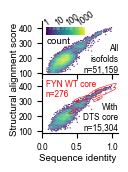

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr
import math
import seaborn as sns

plt.rcParams['font.family'] = 'Arial'

xlim=(min(reliable_isofolds['SeqId'].values.astype(float)),max(reliable_isofolds['SeqId'].values.astype(float)))
ylim=(min(reliable_isofolds['Score'].values.astype(float)),max(reliable_isofolds['Score'].values.astype(float)))

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(1.3,1.6))
coliterator=0
rowiterator=0
for panel in range(1,3,1):
    
    if panel == 1:
        y = reliable_isofolds['Score'].values.astype(float)
        x = reliable_isofolds['SeqId'].values.astype(float)
        #ax[coliterator].set_title('Isofolds with a\nDTS-encoded core', fontsize=7)
        ax[coliterator].annotate('All\nisofolds\nn='+f"{len(x):,}", (1.1,110), fontsize=6, ha='right')
        ax[coliterator].set_xticklabels([])
    elif panel == 2:
        y = reliable_isofolds.loc[reliable_isofolds['allDTS']==True]['Score'].values.astype(float)
        x = reliable_isofolds.loc[reliable_isofolds['allDTS']==True]['SeqId'].values.astype(float)
        #y = reliable_isofolds.loc[reliable_isofolds['WTcore']==True]['Score'].values.astype(float)
        #x = reliable_isofolds.loc[reliable_isofolds['WTcore']==True]['SeqId'].values.astype(float)
        #ax[coliterator].set_title('Isofolds with the same\ncore as FYN-SH3', fontsize=7)
        ax[coliterator].annotate('With\nDTS core\nn='+f"{len(x):,}", (1.1,110), fontsize=6, ha='right')
        ax[coliterator].annotate('FYN WT core\nn='+f"{len(reliable_isofolds.loc[reliable_isofolds['WTcore']==True].index):,}", (0.05,330), fontsize=6, ha='left', color='red')
    
    model = LinearRegression()
    model.fit(x.reshape(-1, 1),y.reshape(-1, 1))
    
    y_pred = model.predict(x.reshape(-1, 1))
    
    ax[coliterator].set(xlim=xlim,ylim=ylim)
    hbin=ax[coliterator].hexbin(x,y,gridsize=50,bins='log', vmax=1000, rasterized=True,linewidths=0, extent=[min(reliable_isofolds['SeqId'].values.astype(float)),max(reliable_isofolds['SeqId'].values.astype(float)),min(reliable_isofolds['Score'].values.astype(float)),max(reliable_isofolds['Score'].values.astype(float))])
    if panel == 2:
        sns.kdeplot(data=reliable_isofolds.loc[reliable_isofolds['WTcore']==True], x='SeqId', y='Score', thresh=0.001,linewidths=0.4, fill=False, levels=3, alpha=1,ax=ax[coliterator], color='red')#, label='FYN WT core\nn='+f"{len(reliable_isofolds.loc[reliable_isofolds['WTcore']==True].index):,}")
    ax[coliterator].axline((0, 0), slope=1,ls='dashed',color='k',lw=0.5)
    ax[coliterator].set_ylim(min(reliable_isofolds['Score'].values.astype(float))*0.9,max(reliable_isofolds['Score'].values.astype(float))*1.1)
    ax[coliterator].set_xlim(0,1.1)
    ax[coliterator].spines[['right','top']].set_visible(False)
    ax[coliterator].set_ylabel('')
    ax[coliterator].set_xlabel('')
    ax[coliterator].set_yticks(np.arange(100,500,100), labels=np.arange(100,500,100))
    ax[coliterator].tick_params(axis='x', labelsize=6)
    ax[coliterator].tick_params(axis='y', labelsize=6)
    ax[coliterator].set_rasterization_zorder(0)
    coliterator+=1


fmt = '%1.f'
cax=fig.add_axes([0.33,0.82,0.3,0.05])
cb=fig.colorbar(hbin, ax=ax, shrink=0.7,format=fmt,location='top',cax=cax)
cb.outline.set_visible(False)
cb.ax.tick_params(axis='both', which='both',direction='in', color='white',width=0.15)
cb.ax.xaxis.set_tick_params(pad=0)
cb.set_ticks([1,10,100,1000])
cb.set_ticklabels([1,10,100,1000], fontsize=6, rotation=35)
ax1 = cb.ax
ax1.text(1,-1,'count',rotation=0, fontsize=7)

fig.text(0.57, 0.04, 'Sequence identity', ha='center', fontsize=7)
fig.text(0.05, 0.55, 'Structural alignment score', va='center', rotation='vertical', fontsize=7)
fig.tight_layout()
fig.subplots_adjust(hspace=0.1)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_isofold_foldseek_overview.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel c

In [5]:
import pandas as pd

predicted_phenotypes = pd.read_csv(path+'Fig3/FYN-SH3/FYN_mochi_order2/task_1/predictions/predicted_phenotypes_supp.txt',
                                  sep='\t', lineterminator='\n', index_col=0, low_memory=False)

/var/folders/32/dtq6y36s6mjg1zcf2_9dskdm0000gn/T/ipykernel_7376/776368025.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  predicted_phenotypes = pd.read_csv(path+'Fig3/FYN-SH3/FYN_mochi_order2/task_1/predictions/predicted_phenotypes_supp.txt',


In [6]:
cores = {'P06241' : [2,16,18,24,26,48,53]}

for index, row in predicted_phenotypes.iterrows():
    core=[]
    for i in cores['P06241']:
        core.append(row.aa_seq[i])
    predicted_phenotypes.at[index,'core'] = ''.join(core)

In [7]:
RT=303*0.001987
predicted_phenotypes['mean_additive_trait']=predicted_phenotypes[['fold_1_additive_trait0','fold_2_additive_trait0','fold_3_additive_trait0','fold_4_additive_trait0','fold_5_additive_trait0','fold_6_additive_trait0','fold_7_additive_trait0','fold_8_additive_trait0','fold_9_additive_trait0','fold_10_additive_trait0']].mean(axis=1)
predicted_phenotypes['std_additive_trait']=predicted_phenotypes[['fold_1_additive_trait0','fold_2_additive_trait0','fold_3_additive_trait0','fold_4_additive_trait0','fold_5_additive_trait0','fold_6_additive_trait0','fold_7_additive_trait0','fold_8_additive_trait0','fold_9_additive_trait0','fold_10_additive_trait0']].std(axis=1)

predicted_phenotypes['mean']=predicted_phenotypes[['fold_1','fold_2','fold_3','fold_4','fold_5','fold_6','fold_7','fold_8','fold_9','fold_10']].mean(axis=1)
predicted_phenotypes['std']=predicted_phenotypes[['fold_1','fold_2','fold_3','fold_4','fold_5','fold_6','fold_7','fold_8','fold_9','fold_10']].std(axis=1)

predicted_phenotypes['mean_dG']= predicted_phenotypes['mean_additive_trait']*RT
predicted_phenotypes['std_dG']= predicted_phenotypes['std_additive_trait']*RT

In [8]:
from itertools import product

DTS = ['F','L','I','M','V']
a=list(product(DTS,repeat=7))

isofold_exist_clasf = pd.DataFrame(index=[''.join(i) for i in a])

isofold_exist_clasf = isofold_exist_clasf.join(predicted_phenotypes.set_index('core')[['mean_dG']])

isofold_exist_clasf['in_nature_all']=isofold_exist_clasf.index.isin(list(reliable_isofolds.loc[reliable_isofolds['allDTS']==True].drop_duplicates('MutCore')['MutCore']))
isofold_exist_clasf['in_nature_all']=isofold_exist_clasf['in_nature_all'].astype(int)
isofold_exist_clasf['in_nature_25_50']=isofold_exist_clasf.index.isin(list(reliable_isofolds.loc[reliable_isofolds['allDTS']==True].loc[reliable_isofolds['SeqId']<0.5].loc[reliable_isofolds['SeqId']>0.25].drop_duplicates('MutCore')['MutCore']))
isofold_exist_clasf['in_nature_25_50']=isofold_exist_clasf['in_nature_25_50'].astype(int)
isofold_exist_clasf['in_nature_50_75']=isofold_exist_clasf.index.isin(list(reliable_isofolds.loc[reliable_isofolds['allDTS']==True].loc[reliable_isofolds['SeqId']<0.75].loc[reliable_isofolds['SeqId']>0.50].drop_duplicates('MutCore')['MutCore']))
isofold_exist_clasf['in_nature_50_75']=isofold_exist_clasf['in_nature_50_75'].astype(int)
isofold_exist_clasf['in_nature_0_25']=isofold_exist_clasf.index.isin(list(reliable_isofolds.loc[reliable_isofolds['allDTS']==True].loc[reliable_isofolds['SeqId']<0.25].loc[reliable_isofolds['SeqId']>0].drop_duplicates('MutCore')['MutCore']))
isofold_exist_clasf['in_nature_0_25']=isofold_exist_clasf['in_nature_0_25'].astype(int)
isofold_exist_clasf['in_nature_75']=isofold_exist_clasf.index.isin(list(reliable_isofolds.loc[reliable_isofolds['allDTS']==True].loc[reliable_isofolds['SeqId']>0.75].drop_duplicates('MutCore')['MutCore']))
isofold_exist_clasf['in_nature_75']=isofold_exist_clasf['in_nature_75'].astype(int)
isofold_exist_clasf


,mean_dG,in_nature_all,in_nature_25_50,in_nature_50_75,in_nature_0_25,in_nature_75
FFFFFFF,1.292577,0,0,0,0,0
FFFFFFL,2.495111,0,0,0,0,0
FFFFFFI,3.994768,0,0,0,0,0
FFFFFFM,2.653628,0,0,0,0,0
FFFFFFV,2.595477,0,0,0,0,0
...,...,...,...,...,...,...
VVVVVVF,1.350789,0,0,0,0,0
VVVVVVL,1.319200,1,1,0,0,0
VVVVVVI,2.549130,0,0,0,0,0
VVVVVVM,2.258878,0,0,0,0,0


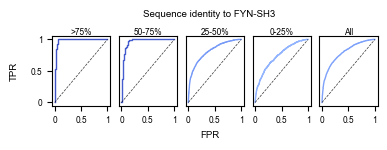

In [9]:
import matplotlib.pyplot as plt
from decimal import Decimal
from sklearn import metrics
from sklearn.model_selection import KFold
from IPython.display import display
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

plt.rcParams["font.family"] = "Arial"

titles = {'in_nature_all':'All',
         'in_nature_0_25':'0-25%',
         'in_nature_25_50':'25-50%',
         'in_nature_50_75':'50-75%',
         'in_nature_75':'>75%'}

cmap = plt.get_cmap('coolwarm_r')

classifier_performances = pd.DataFrame()
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(2.8*1.5,0.6*1.5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.15)
coliterator=0
for threshold in reversed(['in_nature_all', 'in_nature_0_25','in_nature_25_50', 'in_nature_50_75', 'in_nature_75']):

    # predictors (x): ddG
    # target variable (y): exists in nature?
    x = isofold_exist_clasf[['mean_dG']]
    y = isofold_exist_clasf[[threshold]]

    x, y = shuffle(x, y, random_state=3)
    
    # ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(np.array(y).ravel(), np.array(-1*x).ravel())
    roc_auc = metrics.auc(fpr, tpr)
    ax[coliterator].plot(fpr, tpr, lw=1, alpha=1, color=cmap(roc_auc),
            label=r'(AUC=%0.2f)' % (roc_auc))
    
    classifier_performances.at[threshold,'AUC']=roc_auc
    
    ax[coliterator].plot([0, 1], [0, 1], linestyle='--', lw=0.5, color='k',
             label='', alpha=0.8)
        

    ax[coliterator].set_title(titles[threshold],fontsize=6, pad=0)
    ax[coliterator].set_xticks(np.arange(0,1.2,0.5), [Decimal(i).normalize() for i in np.arange(0,1.2,0.5)],fontsize=6)
    ax[coliterator].set_yticks(np.arange(0,1.2,0.5), [Decimal(i).normalize() for i in np.arange(0,1.2,0.5)],fontsize=6)
    if coliterator > 0:
        ax[coliterator].tick_params(axis='y',length=0)
    coliterator+=1
fig.text(0.5, -0.25, 'FPR', ha='center', fontsize=7)
fig.text(0.025, 0.5, 'TPR', va='center', rotation='vertical', fontsize=7)
fig.text(0.5, 1.1, 'Sequence identity to FYN-SH3', ha='center', fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#fig.savefig('FYN_2ndordermodel_EBG_classifier_ROC-AUCs_curves_SeqIds.svg', dpi=300, transparent=True, bbox_inches='tight')

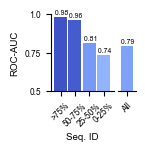

In [10]:
fig, ax = plt.subplot_mosaic([['left','right']],
                            width_ratios = [3.5,1],
                            figsize = (1.1,1))
axis=classifier_performances.iloc[:-1].plot.bar(y='AUC', color=cmap(list(classifier_performances['AUC'])), ax=ax['left'], legend=False, width=0.9, ylim=(0,1.05))
ax['left'].set_xticklabels(reversed(['0-25%', '25-50%', '50-75%', '>75%']), fontsize=6, rotation=45)
ax['left'].set_yticks(np.arange(0,1.2,0.25),[str(round(i,2)) for i in np.arange(0,1.2,0.25)], fontsize=6)
ax['left'].set_ylim(0.5,1)
ax['left'].set_xlabel('Seq. ID', fontsize=7)
ax['left'].set_ylabel('ROC-AUC',fontsize=7)
ax['left'].spines[['top','right']].set_visible(False)

for bar in axis.patches:
    height = bar.get_height()
    axis.text(bar.get_x() + bar.get_width() / 2.0, height+0.01, f' {height:.2f}', fontsize=5,
            ha='center', va='bottom', rotation=0)

axis=classifier_performances.iloc[-1:].plot.bar(y='AUC', color=cmap(list(classifier_performances.iloc[-1:]['AUC'])), ax=ax['right'], legend=False, width=0.9, ylim=(0,1.05))
ax['right'].spines[['top','right','left']].set_visible(False)
ax['right'].set_yticks([])
ax['right'].set_ylim(0.5,1)
ax['right'].set_xticklabels(reversed(['All']), fontsize=6, rotation=45)

for bar in axis.patches:
    height = bar.get_height()
    axis.text(bar.get_x() + bar.get_width() / 2.0, height+0.01, f' {height:.2f}', fontsize=5,
            ha='center', va='bottom', rotation=0)

plt.subplots_adjust(wspace=0.1)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_2ndordermodel_EBG_classifier_ROC-AUCs_SeqIds_2.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel d

In [11]:
from seaborn import kdeplot

predicted_phenotypes_scaled = predicted_phenotypes.copy()

def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]
fig, ax = plt.subplots()

my_kde = kdeplot(data=predicted_phenotypes_scaled, x='mean', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])
    ax.axvline(x[np.argmax(y)], ls='--')

predicted_phenotypes_scaled['mean']=           normalize(list(predicted_phenotypes_scaled['mean']),{'actual': {'lower': mode, 'upper': predicted_phenotypes_scaled.loc[predicted_phenotypes_scaled['WT']==True].iloc[0]['mean']}, 'desired': {'lower': -1, 'upper': 0}})

fig, ax = plt.subplots()

my_kde = kdeplot(data=predicted_phenotypes_scaled, x='mean', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    #mode=(x[np.argmax(y)])
    ax.axvline(x[np.argmax(y)], ls='--')
ax.axvline(0, ls='--')


In [12]:
for index, row in reliable_isofolds.loc[reliable_isofolds['allDTS']==True].iterrows():
    try:
        reliable_isofolds.at[index,'fitness']=predicted_phenotypes_scaled.loc[predicted_phenotypes_scaled['core']==row.MutCore].iloc[0]['mean']
        reliable_isofolds.at[index,'dG']=predicted_phenotypes_scaled.loc[predicted_phenotypes_scaled['core']==row.MutCore].iloc[0]['mean_dG']
    except IndexError:
        pass
    

In [13]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

iterator_cmap = 10

In [14]:
from itertools import product

DTS = ['F','L','I','M','V']
a=list(product(DTS,repeat=7))

from tqdm import tqdm

dod={}
for variant in tqdm(a, total=len(a)):
    iterator=0
    positerator=0
    singles=[]
    for i in product(variant,DTS):
        mutant = ''.join(''.join(variant[:positerator])+str(i[1])+''.join(variant[positerator+1:]))
        if (iterator/5).is_integer() == True and iterator !=0:
            positerator+=1
        iterator+=1
        if mutant != ''.join(variant):
            singles.append(mutant)
    dod[''.join(variant)]=singles

100%|██████████| 78125/78125 [00:01<00:00, 56198.77it/s]


/var/folders/32/dtq6y36s6mjg1zcf2_9dskdm0000gn/T/ipykernel_7376/1720086963.py:53: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=newcmap)
/var/folders/32/dtq6y36s6mjg1zcf2_9dskdm0000gn/T/ipykernel_7376/1169743594.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_yticklabels(labels)


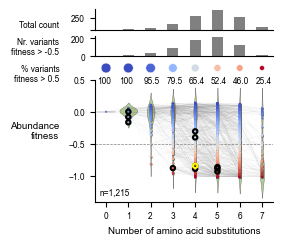

In [15]:
import seaborn as sns
import networkx as nx
from itertools import count
from seaborn import kdeplot
from itertools import groupby
import matplotlib
import numpy as np

query_natural_DTS_cores = ['VLFIVFV', 'VLFIIFV', 'VLLIVFV', 'VLFILFV', 'VLLVVFV', 'VLFLVFV', 'VLIIVFV', 'FLLVVFV']
detrimental_singles = ['LLFFIIV', 'ILFFIIV', 'FVFFIIV', 'FLLFIIV', 'FLIFIIV', 'FLVFIIV', 'FLFMIIV', 'FLFVIIV', 'FLFFFIV', 'FLFFLIV', 'FLFFMIV', 'FLFFIFV', 'FLFFILV', 'FLFFIMV']

natural_core_predictions= reliable_isofolds.loc[reliable_isofolds['allDTS']==True].drop_duplicates('MutCore').copy()
natural_core_predictions = natural_core_predictions.sort_values('fitness',ascending=False)

lines = kdeplot(data=natural_core_predictions, x='fitness').get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=x[np.argmax(y)]

G = nx.from_dict_of_lists(dod)
G_val = nx.from_dict_of_lists(dod)
G_grb2 = nx.from_dict_of_lists(dod)

pos={}
for index, row in natural_core_predictions.iterrows():
    pos[row.MutCore] = (row.Nham, row['fitness'])
    
validated = query_natural_DTS_cores+detrimental_singles
pos_val={}
for index, row in natural_core_predictions[natural_core_predictions['MutCore'].isin(validated)].iterrows():
    pos_val[row.MutCore] = (row.Nham, row.fitness)
    
validated_grb2 = ['VLFIVFV']
pos_grb2={}
for index, row in natural_core_predictions[natural_core_predictions['MutCore'].isin(validated_grb2)].iterrows():
    pos_grb2[row.MutCore] = (row.Nham, row.fitness)
    
fig, (ax0,axviable,ax1,ax2) = plt.subplots(4,1,gridspec_kw={'height_ratios':[2,2,1,12],'hspace': 0.15},figsize=(2.3,2.5),sharex=ax1)


fig=sns.violinplot(x="Nham", y="fitness", data=natural_core_predictions, inner="point", ax=ax2, color='#B4D689', linewidth=0.3)
plt.axhline(y=-0.5, linestyle='--', color='gray', linewidth=0.5)

remove=[i for i in dod.keys() if i not in pos.keys()]
remove_val=[i for i in dod.keys() if i not in pos_val.keys()]
remove_grb2=[i for i in dod.keys() if i not in pos_grb2.keys()]

G.remove_nodes_from(remove)
G_val.remove_nodes_from(remove_val)
G_grb2.remove_nodes_from(remove_grb2)

fitness_values=[]
for i in pos:
    fitness_values.append(pos[i][1])
groups = []
for _, g in groupby(fitness_values, lambda x: (x-1)//0.05):
    groups.append(list(g))      # Store group iterator as a list

fitness_attr={}
for node in G.nodes:
    iterator=0
    for bin in groups:
        if pos[node][1] in bin:
            fitness_attr[node]=iterator
            break
        iterator+=1

nx.set_node_attributes(G, fitness_attr, 'fitness')
groups = set(nx.get_node_attributes(G,'fitness').values())
mapping = dict(zip(sorted(groups),count()))
nodes = G.nodes()
colors = [mapping[G.nodes[n]['fitness']] for n in nodes]

total_viable=0
nham_viability=pd.DataFrame(columns=['Number_of_variants','Fraction_50pc_folded'])
for nham in range(0,8,1):
    nham_viability.at[nham,'nham']=nham
    nham_viability.at[nham,'Fraction_50pc_folded']=round(100*(len(natural_core_predictions.loc[natural_core_predictions['Nham']==nham].loc[natural_core_predictions['fitness']>=-0.5].index)/len(natural_core_predictions.loc[natural_core_predictions['Nham']==nham])),1)
    nham_viability.at[nham,'Number_of_variants']=len(natural_core_predictions.loc[natural_core_predictions['Nham']==nham])
    nham_viability.at[nham,'Number_of_viable_variants']=len(natural_core_predictions.loc[natural_core_predictions['Nham']==nham].loc[natural_core_predictions['fitness']>=-0.5].index)
    total_viable=total_viable+len(natural_core_predictions.loc[natural_core_predictions['Nham']==nham].loc[natural_core_predictions['fitness']>=-0.5].index)
for index, row in nham_viability.iterrows():
    nham_viability.at[index,'Fraction_of_total_viable_variants']= round(100*row['Number_of_viable_variants']/total_viable,1)

orig_cmap = plt.cm.coolwarm
iterator_cmap+=1
midpoint=(-0.5 - np.min(natural_core_predictions['fitness']))/ (np.max(natural_core_predictions['fitness']) - np.min(natural_core_predictions['fitness']))
shifted_cmap = shiftedColorMap(orig_cmap, midpoint=1-midpoint, name='shifted'+str(iterator_cmap))
    
nx.draw_networkx(G, pos=pos, with_labels=False, node_size=0, ax=ax2, edge_color='gray', width=0.02)
nodes=nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, node_size=0.3, cmap=shifted_cmap)
nx.draw_networkx(G_val, pos=pos_val, with_labels=False, node_size=10, ax=ax2, width=0, node_shape=matplotlib.markers.MarkerStyle(marker='o', fillstyle='none'), node_color='k')
nx.draw_networkx(G_grb2, pos=pos_grb2, with_labels=False, node_size=10, ax=ax2, width=0, node_shape=matplotlib.markers.MarkerStyle(marker='o', fillstyle='none'), node_color='yellow')
ax2.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax2.set_xlabel('Number of amino acid substitutions', fontsize=7)
ax2.set_ylabel("Abundance\nfitness", fontsize=7,rotation='horizontal', ha='right')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='both', which='major', labelsize=6)

nham_viability['Fraction_50pc_folded'] = pd.to_numeric(nham_viability['Fraction_50pc_folded'], errors='coerce')
sns.scatterplot(x=[i for i in nham_viability['nham']],y=[0]*len(nham_viability.index), hue=nham_viability['Fraction_50pc_folded'],palette='coolwarm_r', s=nham_viability['Fraction_50pc_folded']*0.5,ax=ax1)
ax1.legend_.remove()
ax1.spines[['top','right','left','bottom']].set_visible(False)
ax1.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False,top=False, right=False)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
for index, row in nham_viability.iterrows():
    if row.Fraction_50pc_folded == 100.0:
        ax2.annotate(100, (row.nham-0.4,0.45), fontsize=6, color='black')
    else:
        ax2.annotate(row.Fraction_50pc_folded, (row.nham-0.3,0.45), fontsize=6, color='black')
ax1.set_ylabel('% variants\nfitness > 0.5',fontsize=6,rotation='horizontal', ha='right')
        
ax2.annotate('n='+f"{len(natural_core_predictions):,}", (-0.3,-1.3), fontsize=6)
plt.subplots_adjust(hspace=0.05)

nham_viability['Number_of_variants'].plot.bar(ax=ax0,fontsize=6,color='gray')
ax0.spines[['top','right']].set_visible(False)
ax0.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax0.set_ylabel('Total count',fontsize=6, rotation='horizontal', ha='right')
labels = ax0.get_yticklabels()
labels[0] = ""
ax0.set_yticklabels(labels)

nham_viability['Number_of_viable_variants'].plot.bar(ax=axviable,fontsize=6,color='gray')
axviable.spines[['top','right']].set_visible(False)
axviable.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axviable.set_ylabel('Nr. variants\nfitness > -0.5',fontsize=6,rotation='horizontal', ha='right')

#fig.text(-3.05, 0.78, 'Viable', rotation='vertical', fontsize=7)
#fig.text(-3.05, 1.42, 'Total', rotation='vertical', fontsize=7)

ax0.get_yaxis().set_label_coords(-0.2,0)
axviable.get_yaxis().set_label_coords(-0.2,0)
ax1.get_yaxis().set_label_coords(-0.2,-1)
ax2.get_yaxis().set_label_coords(-0.2,0.5)
plt.ylim(-1.4,0.5)
plt.xlim(-0.5,7.5)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_isofold_core_predictions_reps12.png', dpi=300, transparent=True, bbox_inches='tight')
#for tick in ax.yaxis.get_majorticklabels():
#    tick.set_horizontalalignment("right")
#cbar=plt.colorbar(nodes)
#cbar.ax.invert_yaxis()
